# 2A.ml - Analyse de sentiments - correction

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) où on utilise la fonction ``load_sentiment_dataset``.

In [4]:
# from ensae_teaching_cs.data import load_sentiment_dataset
# df = load_sentiment_dataset()

import pandas as pd

df = pd.read_csv("../data_text_mining.csv")

df.head()

,raw_text,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


## Exercice 1 : approche tf-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*. On s'occupe des variables catégorielles.

### La variable catégorielle

Ce serait un peu plus simple avec le module [Category Encoders](http://contrib.scikit-learn.org/categorical-encoding/) ou la dernière nouveauté de scikit-learn : [ColumnTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer).

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                df.drop("sentiment", axis=1), df["sentiment"])

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
le.fit(X_train["source"])
X_le = le.transform(X_train["source"])
X_le.shape

(2061,)

In [8]:
X_le_mat = X_le.reshape((X_le.shape[0], 1))

In [9]:
ohe = OneHotEncoder(categories="auto")
ohe.fit(X_le_mat)

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [10]:
X_le_encoded = ohe.transform(X_le_mat)
train_cat = X_le_encoded.todense()
test_cat = ohe.transform(le.transform(X_test["source"]).reshape((len(X_test), 1))).todense()

In [11]:
import pandas
X_train2 = pandas.concat([X_train.reset_index(drop=True),
                          pandas.DataFrame(train_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_train2.head(n=2)

,raw_text,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,My 8/10 score is mostly for the plot.,imdb_labelled,0.0,1.0,0.0
1,This was like the final blow!,yelp_labelled,0.0,0.0,1.0


In [29]:
X_test2 = pandas.concat([X_test.reset_index(drop=True),
                         pandas.DataFrame(test_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_test2.head(n=2)

,raw_text,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,I rate this movie 9/10.,imdb_labelled,0.0,1.0,0.0
1,Phone falls out easily.,amazon_cells_labelled,1.0,0.0,0.0


### tokenisation

On tokenise avec le module [spacy](https://spacy.io/usage/spacy-101#annotations-token) qui requiert des données supplémentaires pour découper en mot avec ``pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz`` selon les instructions dévoilées dans le [guide de départ](https://spacy.io/usage/models) ou encore ``python -m spacy download en``. Le module [gensim](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/artificiel_tokenize.html?highlight=tokenisation#gensim) ne requiert pas d'installation. On peut aussi s'inspirer de l'example [word2vec pré-entraînés](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html#word2vec-pre-entraines).

In [12]:
import spacy
nlp = spacy.load("en_core_web_sm")
# Ca marche après avoir installé le corpus correspondant
# python -m spacy download en_core_web_sm

In [14]:
X_train2.iloc[0, 0]

'My 8/10 score is mostly for the plot.  '

In [13]:
doc = nlp(X_train2.iloc[0,0])
[token.text for token in doc]

['My', '8/10', 'score', 'is', 'mostly', 'for', 'the', 'plot', '.', ' ']

In [15]:
"Apple".lower()

'apple'

### tf-idf

Une fois que les mots sont tokenisé, on peut appliquer le *tf-idf*.

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
tokenizer = lambda text: [token.text.lower() for token in nlp(text)]
count = CountVectorizer(tokenizer=tokenizer, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [24]:
pipe.fit(X_train["raw_text"])

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x0000016AF89A1BF8>,
                                 vocabulary=None)),
                ('tfidftransformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True))],
         verbose=False)

In [25]:
train_feature = pipe.transform(X_train2["raw_text"])
train_feature

<2061x4460 sparse matrix of type '<class 'numpy.float64'>'
	with 28062 stored elements in Compressed Sparse Row format>

In [26]:
dense_train = train_feature.todense()

In [27]:
dense_train

matrix([[0.        , 0.15190268, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [30]:
test_feature = pipe.transform(X_test2["raw_text"])

### Combinaison de toutes les variables

In [31]:
train_feature.shape, train_cat.shape

((2061, 4460), (2061, 3))

In [32]:
import numpy
np_train = numpy.hstack([train_feature.todense(), train_cat])
np_test = numpy.hstack([test_feature.todense(), test_cat])

### Calage d'un modèle

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(np_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
rf.score(np_test, y_test)

0.7583697234352256

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity). Avec [spacy](https://spacy.io/usage/vectors-similarity), c'est assez simple :

In [24]:
vv = nlp(X_train2.iloc[0, 0])
list(vv)[0].vector[:10], vv.vector.shape

(array([-0.8488054 , -1.947987  , -0.63993007, -2.515422  ,  0.1763793 ,
         6.6593666 ,  4.1674576 ,  0.01300871, -0.20696199, -1.615491  ],
       dtype=float32), (96,))

On fait la somme.

In [25]:
sum([_.vector for _ in vv])[:10]

array([  9.809447 , -13.074627 , -40.26146  , -50.89205  ,  -7.1937313,
        39.825134 , -10.759298 ,  33.54933  ,   4.0041533,  28.559126 ],
      dtype=float32)

In [26]:
np_train_vect = numpy.zeros((X_train2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_train2["raw_text"]):
    np_train_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [27]:
np_test_vect = numpy.zeros((X_test2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_test2["raw_text"]):
    np_test_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [28]:
np_train_v = numpy.hstack([np_train_vect, train_cat])
np_test_v = numpy.hstack([np_test_vect, test_cat])

In [29]:
rfv = RandomForestClassifier(n_estimators=50)
rfv.fit(np_train_v, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
rfv.score(np_test_v, y_test)

0.6579330422125182

Moins bien...

## Exercice 3 : comparer les deux approches

Avec une courbe [ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) par exemple.

In [31]:
pmodel1 = rf.predict_proba(np_test)[:, 1]
pmodel2 = rfv.predict_proba(np_test_v)[:, 1]

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr1, tpr1, th1 = roc_curve(y_test, pmodel1)
fpr2, tpr2, th2 = roc_curve(y_test, pmodel2)

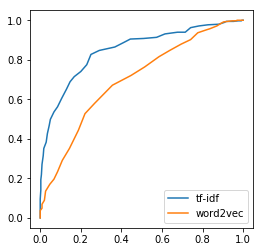

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='tf-idf')
ax.plot(fpr2, tpr2, label='word2vec')
ax.legend();

## Petite analyse d'erreurs

On combine les erreurs des modèles sur la base de test.

In [35]:
final = X_test.copy()
final["model1"] = pmodel1
final["model2"] = pmodel2
final["label"] = y_test
final.head()

,raw_text,source,model1,model2,label
1845,Food arrived quickly!,yelp_labelled,0.68,0.48,1
2101,It shouldn't take 30 min for pancakes and eggs.,yelp_labelled,0.32,0.36,0
793,I bought this battery with a coupon from Amazo...,amazon_cells_labelled,0.68,0.50,1
1627,It's pretty surprising that this wonderful fil...,imdb_labelled,0.74,0.58,1
2190,"Anyway, this FS restaurant has a wonderful bre...",yelp_labelled,0.70,0.76,1


On regarde des erreurs.

In [36]:
erreurs = final[final["label"] == 1].sort_values("model2")
erreurs.head()

,raw_text,source,model1,model2,label
2487,Never had anything to complain about here.,yelp_labelled,0.50,0.20,1
934,You get extra minutes so that you can carry ou...,amazon_cells_labelled,0.20,0.24,1
226,I usually don't like headbands but this one is...,amazon_cells_labelled,0.20,0.26,1
2196,"The food is delicious and just spicy enough, s...",yelp_labelled,0.54,0.28,1
302,Someone shouldve invented this sooner.,amazon_cells_labelled,0.28,0.28,1


In [38]:
list(erreurs["raw_text"])[:5]

['Never had anything to complain about here.',
 'You get extra minutes so that you can carry out the call and not get cut off."',
 "I usually don't like headbands but this one is very lightweight & doesn't mess up my hair.",
 'The food is delicious and just spicy enough, so be sure to ask for spicier if you prefer it that way.',
 'Someone shouldve invented this sooner.']

Le modèle 2 reconnaît mal les négations visiblement. On regarde le modèle 1.

In [39]:
erreurs = final[final["label"] == 1].sort_values("model1")
erreurs.head()

,raw_text,source,model1,model2,label
2074,You won't be disappointed.,yelp_labelled,0.08,0.32,1
2161,I can assure you that you won't be disappointed.,yelp_labelled,0.14,0.46,1
1107,"Still, I do like this movie for it's empowerme...",imdb_labelled,0.18,0.28,1
817,Gets a signal when other Verizon phones won't.,amazon_cells_labelled,0.18,0.46,1
1289,"Lifetime does not air it enough, so if anyone ...",imdb_labelled,0.20,0.38,1


In [41]:
list(erreurs["raw_text"])[:5]

["You won't be disappointed.",
 "I can assure you that you won't be disappointed.",
 "Still, I do like this movie for it's empowerment of women; there's not enough movies out there like this one.  ",
 "Gets a signal when other Verizon phones won't.",
 'Lifetime does not air it enough, so if anyone knows what store sells it let me know because this is a must-have.  ']

Idem, voyons là où les modèles sont en désaccords.

In [42]:
final["diff"] = final.model1 - final.model2

In [43]:
erreurs = final[final["label"] == 1].sort_values("diff")
erreurs.head()

,raw_text,source,model1,model2,label,diff
1493,Shot in the Southern California desert using h...,imdb_labelled,0.28,0.70,1,-0.42
1684,The two main characters may be two of the most...,imdb_labelled,0.22,0.60,1,-0.38
214,fast service.,amazon_cells_labelled,0.26,0.64,1,-0.38
1669,"Not much dialogue, not much music, the whole f...",imdb_labelled,0.24,0.56,1,-0.32
1595,This mostly routine fact-based TV drama gets a...,imdb_labelled,0.44,0.76,1,-0.32


In [44]:
erreurs.tail()

,raw_text,source,model1,model2,label,diff
2045,I love the fact that everything on their menu ...,yelp_labelled,0.80,0.42,1,0.38
2140,"I have been here several times in the past, an...",yelp_labelled,0.84,0.42,1,0.42
963,I use this product in a motor control center w...,amazon_cells_labelled,0.84,0.40,1,0.44
971,Excellent product.,amazon_cells_labelled,0.80,0.32,1,0.48
1217,"As a European, the movie is a nice throwback t...",imdb_labelled,0.86,0.36,1,0.50


Le modèle 2 (word2vec) a l'air meilleur sur les phrases longues, le modèle 1 (tf-idf) saisit mieux les mots positifs. A confirmer sur plus de données. 

* Enlever les stop words, les signes de ponctuation.
* Combiner les deux approches.
* n-grammes
* ...

Dernière analyse en regardant le taux d'erreur par source.

In [45]:
r1 = rf.predict(np_test)
r2 = rfv.predict(np_test_v)
final["rep1"] = r1
final["rep2"] = r2
final["err1"] = (final.label - final.rep1).abs()
final["err2"] = (final.label - final.rep2).abs()
final["total"] = 1
final.head()

,raw_text,source,model1,model2,label,diff,rep1,rep2,err1,err2,total
1845,Food arrived quickly!,yelp_labelled,0.68,0.48,1,0.20,1,0,0,1,1
2101,It shouldn't take 30 min for pancakes and eggs.,yelp_labelled,0.32,0.36,0,-0.04,0,0,0,0,1
793,I bought this battery with a coupon from Amazo...,amazon_cells_labelled,0.68,0.50,1,0.18,1,0,0,1,1
1627,It's pretty surprising that this wonderful fil...,imdb_labelled,0.74,0.58,1,0.16,1,1,0,0,1
2190,"Anyway, this FS restaurant has a wonderful bre...",yelp_labelled,0.70,0.76,1,-0.06,1,1,0,0,1


In [46]:
final[["source", "err1", "err2", "total"]].groupby("source").sum()

,err1,err2,total
source,,,
amazon_cells_labelled,44,71,243
imdb_labelled,50,69,188
yelp_labelled,64,95,256


*imdb* paraît une source une peu plus difficile à saisir. Quoiqu'il en soit, 2000 phrases pour apprendre est assez peu pour apprendre.

## Versions utilisées pour ce notebook

[spacy](https://spacy.io/) s'est montré quelque peu fantasques cette année avec quelques erreurs notamment celle-ci :
[ValueError: cymem.cymem.Pool has the wrong size, try recompiling](https://github.com/explosion/spaCy/issues/2852). Voici les versions utilisées...

In [42]:
def version(module, sub=True):
    try:
        ver = getattr(module, '__version__', None)
        if ver is None:
            ver = [_ for _ in os.listdir(os.path.join(module.__file__, '..', '..' if sub else '')) \
                   if module.__name__ in _ and 'dist' in _][-1]
        return ver
    except Exception as e:
        return str(e)

In [43]:
import os
import thinc
print("thinc", version(thinc))
import preshed
print("preshed", version(preshed))
import cymem
print("cymem", version(cymem))
import murmurhash
print("murmurhash", version(murmurhash))
import plac
print("plac", plac.__version__)
import spacy
print("spacy", spacy.__version__)

import msgpack
print("msgpack", version(msgpack))
import numpy
print("numpy", numpy.__version__)

thinc 7.0.4
preshed preshed-2.0.1.dist-info
cymem cymem-2.0.2.dist-info
murmurhash murmurhash-1.0.2.dist-info
plac 0.9.6
spacy 2.1.4
msgpack msgpack-0.6.1.dist-info
numpy 1.16.2
